In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple, Dict
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import KFold
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

from rpy2.robjects import r
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import default_converter
from rpy2.robjects import pandas2ri, conversion
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
from rpy2.robjects import Formula
from rpy2.robjects.vectors import FloatVector, IntVector, ListVector, Vector, StrVector
from rpy2.robjects import DataFrame, IntVector

rstpm2 = importr("rstpm2")
survival = importr("survival")
ggplot2 = importr("ggplot2")
graphics = importr("graphics")
stats = importr("stats")
lmtest = importr("lmtest")

In [50]:
dfs = pd.read_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/combined_other_datasets_for_modeling.csv')
dfs1 = dfs.copy()

print(dfs1.shape)
print()
print(dfs1.info())
print()
dfs1.head(3)


(1678, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1678 entries, 0 to 1677
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_id        1678 non-null   object 
 1   Event             1678 non-null   float64
 2   Vital_capacity    1678 non-null   float64
 3   Sex               1678 non-null   object 
 4   Onset_site        1678 non-null   object 
 5   Study_Arm         1678 non-null   object 
 6   European          1678 non-null   int64  
 7   Age               1678 non-null   float64
 8   Diagnostic_Delay  1678 non-null   float64
 9   Disease_Duration  1678 non-null   float64
 10  TRICALS           1678 non-null   float64
 11  Study_id          1678 non-null   object 
 12  Expt              1678 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 170.6+ KB
None



,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals


In [51]:
print(f"Expt: {dfs1['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {dfs1['Study_id'].value_counts().to_dict()}")

Expt: {'riluzole': 1282, 'mirocals': 220, 'licals': 176}

Study_id: {'301': 959, 'miro': 220, 'lica': 176, '302': 168, '216': 155}


In [52]:
df = dfs1[dfs1['Expt'] != 'riluzole']
print(f"Expt: {df['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df['Study_id'].value_counts().to_dict()}")

df.shape

Expt: {'mirocals': 220, 'licals': 176}

Study_id: {'miro': 220, 'lica': 176}


(396, 13)

In [53]:
df_new = dfs1[dfs1['Study_id'] == '301']
print(f"Expt: {df_new['Expt'].value_counts().to_dict()}\n")
print(f"Study_id: {df_new['Study_id'].value_counts().to_dict()}")

print(df_new.shape)
df_new.head(3)

Expt: {'riluzole': 959}

Study_id: {'301': 959}
(959, 13)


,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,301,riluzole
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,301,riluzole
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,301,riluzole


In [54]:
df = df.copy()
df['Ages'] = (df['Age'] - df['Age'].mean()) / df['Age'].std()
df['TRICALSs'] = (df['TRICALS'] - df['TRICALS'].mean()) / df['TRICALS'].std()

df_new = df_new.copy()
df_new['Ages'] = (df_new['Age'] - df_new['Age'].mean()) / df_new['Age'].std()
df_new['TRICALSs'] = (df_new['TRICALS'] - df_new['TRICALS'].mean()) / df_new['TRICALS'].std()

df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109


In [55]:
df_new.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,301,riluzole,0.665206,1.189157
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,301,riluzole,-1.339438,-1.653300
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,301,riluzole,0.482966,0.644593


In [56]:
df_time_var = df[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time_var.describe()

df_new = df_new[df_new['Diagnostic_Delay'] >= 0]
df_time_var = df_new[['Disease_Duration', 'Diagnostic_Delay', 'Vital_capacity']]
df_time_var.describe()
# df_time.isna().sum()



,Disease_Duration,Diagnostic_Delay,Vital_capacity
count,957.000000,957.000000,957.000000
mean,14.065459,0.122412,88.210751
std,5.193630,0.253610,18.850001
min,0.164258,0.000000,44.117647
25%,11.005256,0.000000,73.228141
50%,16.097240,0.000000,85.397096
75%,18.035480,0.131406,101.857062
max,22.667543,2.036794,157.367668


In [57]:
df['Disease_Durationl'] = np.log1p(df['Disease_Duration']) # ln(1 + x)
df['Diagnostic_Delayl'] = np.log1p(df['Diagnostic_Delay']) # ln(1 + x)
df['Vital_capacityl'] = np.log(df['Vital_capacity']) # ln(x)


df_new['Disease_Durationl'] = np.log1p(df_new['Disease_Duration']) # ln(1 + x)
df_new['Diagnostic_Delayl'] = np.log1p(df_new['Diagnostic_Delay']) # ln(1 + x)
df_new['Vital_capacityl'] = np.log(df_new['Vital_capacity']) # ln(x)


df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973


In [58]:
df_new.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,301,riluzole,0.665206,1.189157,2.099444,0.206982,4.312395
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,301,riluzole,-1.339438,-1.653300,3.003325,0.000000,4.848577
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,301,riluzole,0.482966,0.644593,2.956606,0.378382,4.390385


In [59]:
df['Disease_Durationls'] = (df['Disease_Durationl'] - df['Disease_Durationl'].mean()) / df['Disease_Durationl'].std()
df['Diagnostic_Delayls'] = (df['Diagnostic_Delayl'] - df['Diagnostic_Delayl'].mean()) / df['Diagnostic_Delayl'].std()
df['Vital_capacityls'] = (df['Vital_capacityl'] - df['Vital_capacityl'].mean()) / df['Vital_capacityl'].std()

df_new['Disease_Durationls'] = (df_new['Disease_Durationl'] - df_new['Disease_Durationl'].mean()) / df_new['Disease_Durationl'].std()
df_new['Diagnostic_Delayls'] = (df_new['Diagnostic_Delayl'] - df_new['Diagnostic_Delayl'].mean()) / df_new['Diagnostic_Delayl'].std()
df_new['Vital_capacityls'] = (df_new['Vital_capacityl'] - df_new['Vital_capacityl'].mean()) / df_new['Vital_capacityl'].std()

df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls
0,P01001,0.0,107.0,Male,Limb,Placebo,1,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667
1,P01002,1.0,99.0,Female,Limb,Placebo,1,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582
2,P01003,0.0,102.0,Male,Limb,Active,1,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973,0.586210,0.616453,0.564421


In [60]:
df_new.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls
551,11001,1.0,74.619023,1,1.0,ACTIVE,1,64.0,0.229961,7.161629,-1.973438,301,riluzole,0.665206,1.189157,2.099444,0.206982,4.312395,-1.002116,0.607142,-0.679668
552,11002,0.0,127.558757,1,1.0,PLACEBO,1,42.0,0.000000,19.152431,-3.891616,301,riluzole,-1.339438,-1.653300,3.003325,0.000000,4.848577,0.757981,-0.530260,1.838548
553,11003,1.0,80.671485,1,1.0,ACTIVE,1,62.0,0.459921,18.232589,-2.340926,301,riluzole,0.482966,0.644593,2.956606,0.378382,4.390385,0.667007,1.549016,-0.313383


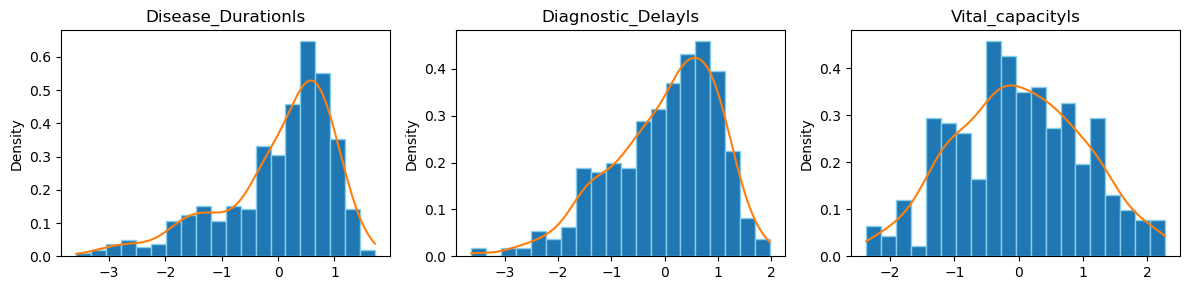

In [61]:
df_time = df[['Disease_Durationls', 'Diagnostic_Delayls', 'Vital_capacityls']]
df_time.describe()

# Plot histogram and density
cols = df_time.columns
n_per_row = 3
n_rows = int(np.ceil(len(cols) / n_per_row))


fig, axes = plt.subplots(
    n_rows, n_per_row,
    figsize=(4 * n_per_row, 3 * n_rows)
)

axes = axes.flatten()

for ax, col in zip(axes, cols):
    data = df_time[col].dropna()

    ax.hist(data, bins=20, density=True, edgecolor='skyblue')

    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 300)
    ax.plot(x, kde(x))

    ax.set_title(col)
    ax.set_ylabel('Density')

for ax in axes[len(cols):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



In [62]:
df['European'] = df['European'].astype('int')
df['Event'] = df['Event'].astype('int')

df_new = df_new.copy()
df_new['European'] = df_new['European'].astype('int')
df_new['Event'] = df_new['Event'].astype('int')

In [63]:
print(f'Event: {df['Event'].value_counts().to_dict()}\n')
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

print("#--------------------#")

print(f'Event: {df_new['Event'].value_counts().to_dict()}\n')
print(f'Expt: {df_new['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df_new['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df_new['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df_new['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df_new['European'].value_counts().to_dict()}\n')


Event: {0: 240, 1: 156}

Expt: {'mirocals': 220, 'licals': 176}

Onset_site: {'Limb': 318, 'Bulbar': 77, 'Other': 1}

Sex: {'M': 136, 'Male': 126, 'F': 84, 'Female': 50}

Study_Arm: {'Placebo': 197, 'IL2': 110, 'Active': 89}

European: {1: 392, 0: 4}

#--------------------#
Event: {0: 531, 1: 426}

Expt: {'riluzole': 957}

Onset_site: {'1.0': 913, '2.0': 44}

Sex: {'1': 573, '0': 384}

Study_Arm: {'ACTIVE': 715, 'PLACEBO': 242}

European: {1: 936, 2: 8, 3: 6, 4: 6, 5: 1}



In [64]:
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar', 'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

df['Onset_site'] = df['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

df['Sex'] = df['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df['Study_Arm'] = df['Study_Arm'].map(mapping2)

#________
df['European'] = np.where(df['European'] == 0, 'Non-European', 'European')


#-----------------------------------------------
# df_new = df_new.copy()
mapping = {'Limb': 'Limb', 'Bulbar': 'Bulbar', 'Other': 'Limb', '1.0': 'Limb',
           '0.0': 'Bulbar', '2.0': 'Bulbar', 1.0: 'Limb', 0.0: 'Bulbar'}

df_new['Onset_site'] = df_new['Onset_site'].map(mapping)

#________
mapping1 = {'M': 'Male', 'F': 'Female', 'Male': 'Male','Female': 'Female', '1': 'Male', '0': 'Female'}

df_new['Sex'] = df_new['Sex'].map(mapping1)

#________
mapping2 = {'IL2': 'Active', 'ACTIVE': 'Active','PLACEBO': 'Placebo', 
            'Active': 'Active','Placebo': 'Placebo'}

df_new['Study_Arm'] = df_new['Study_Arm'].map(mapping2)

#________
df_new['European'] = np.where(df_new['European'] == 0, 'Non-European', 'European')

In [65]:
print(f'Expt: {df['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df['European'].value_counts().to_dict()}\n')

print("#--------------------#")

print(f'Expt: {df_new['Expt'].value_counts().to_dict()}\n')
print(f'Onset_site: {df_new['Onset_site'].value_counts().to_dict()}\n')
print(f'Sex: {df_new['Sex'].value_counts().to_dict()}\n')
print(f'Study_Arm: {df_new['Study_Arm'].value_counts().to_dict()}\n')
print(f'European: {df_new['European'].value_counts().to_dict()}\n')

Expt: {'mirocals': 220, 'licals': 176}

Onset_site: {'Limb': 319, 'Bulbar': 77}

Sex: {'Male': 262, 'Female': 134}

Study_Arm: {'Active': 199, 'Placebo': 197}

European: {'European': 392, 'Non-European': 4}

#--------------------#
Expt: {'riluzole': 957}

Onset_site: {'Limb': 913, 'Bulbar': 44}

Sex: {'Male': 573, 'Female': 384}

Study_Arm: {'Active': 715, 'Placebo': 242}

European: {'European': 957}



In [66]:
df.head(3)

,subject_id,Event,Vital_capacity,Sex,Onset_site,Study_Arm,European,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Expt,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls
0,P01001,0,107.0,Male,Limb,Placebo,European,54.762491,13.600526,32.600526,-4.921357,lica,licals,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667
1,P01002,1,99.0,Female,Limb,Placebo,European,61.160849,20.137976,41.538765,-6.347018,lica,licals,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582
2,P01003,0,102.0,Male,Limb,Active,European,46.702259,15.571616,34.571616,-6.373852,lica,licals,-1.123785,-1.189109,3.571548,2.807691,4.624973,0.586210,0.616453,0.564421


In [67]:
# Identify categorical columns
cat_cols = ['Onset_site', 'European', 'Sex', 'Study_Arm','Expt']

# One-hot encode
df_onehot = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# One-hot encode new data
df_onehot_new = pd.get_dummies(df_new, columns=cat_cols, drop_first=True)

df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667,True,False,True,True,False
1,P01002,1,99.0,61.160849,20.137976,41.538765,-6.347018,lica,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582,True,False,False,True,False


In [68]:
df_onehot.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Ages', 'TRICALSs',
       'Disease_Durationl', 'Diagnostic_Delayl', 'Vital_capacityl',
       'Disease_Durationls', 'Diagnostic_Delayls', 'Vital_capacityls',
       'Onset_site_Limb', 'European_Non-European', 'Sex_Male',
       'Study_Arm_Placebo', 'Expt_mirocals'],
      dtype='object')

In [69]:
df_onehot_new.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Ages', 'TRICALSs',
       'Disease_Durationl', 'Diagnostic_Delayl', 'Vital_capacityl',
       'Disease_Durationls', 'Diagnostic_Delayls', 'Vital_capacityls',
       'Onset_site_Limb', 'Sex_Male', 'Study_Arm_Placebo'],
      dtype='object')

In [70]:
cols = ['Onset_site_Limb', 'Sex_Male', 'Study_Arm_Placebo']

# Convert one-hot encoded columns to int
for col in cols:
    df_onehot[col] = df_onehot[col].astype(int)


# Convert one-hot encoded columns new data to int
for col in cols:
    df_onehot_new[col] = df_onehot_new[col].astype(int)


df_onehot.head(3)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals
0,P01001,0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667,1,False,1,1,False
1,P01002,1,99.0,61.160849,20.137976,41.538765,-6.347018,lica,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582,1,False,0,1,False
2,P01003,0,102.0,46.702259,15.571616,34.571616,-6.373852,lica,-1.123785,-1.189109,3.571548,2.807691,4.624973,0.586210,0.616453,0.564421,1,False,1,0,False


In [71]:
df_onehot_new.head(3)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,Sex_Male,Study_Arm_Placebo
551,11001,1,74.619023,64.0,0.229961,7.161629,-1.973438,301,0.665206,1.189157,2.099444,0.206982,4.312395,-1.002116,0.607142,-0.679668,1,1,0
552,11002,0,127.558757,42.0,0.000000,19.152431,-3.891616,301,-1.339438,-1.653300,3.003325,0.000000,4.848577,0.757981,-0.530260,1.838548,1,1,1
553,11003,1,80.671485,62.0,0.459921,18.232589,-2.340926,301,0.482966,0.644593,2.956606,0.378382,4.390385,0.667007,1.549016,-0.313383,1,1,0


In [72]:
# Create interactions
df_onehot['Sex_onset'] = df_onehot['Sex_Male']*df_onehot['Onset_site_Limb']
df_onehot['Age_Sex'] = df_onehot['Sex_Male']*df_onehot['Ages']
df_onehot['Age_onset'] = df_onehot['Ages']*df_onehot['Onset_site_Limb']
df_onehot['Age_TRICALS'] = df_onehot['Ages']*df_onehot['TRICALSs']
# df_onehot['Trical : Placebo Arm'] = df_onehot['TRICALS']*df_onehot['Study_Arm_Placebo']


# Create interactions for new data
df_onehot_new['Sex_onset'] = df_onehot_new['Sex_Male']*df_onehot_new['Onset_site_Limb']
df_onehot_new['Age_Sex'] = df_onehot_new['Sex_Male']*df_onehot_new['Ages']
df_onehot_new['Age_onset'] = df_onehot_new['Ages']*df_onehot_new['Onset_site_Limb']
df_onehot_new['Age_TRICALS'] = df_onehot_new['Ages']*df_onehot_new['TRICALSs']
# df_onehot_new['Trical : Placebo Arm'] = df_onehot_new['TRICALS']*df_onehot_new['Study_Arm_Placebo']


# df_onehot.info()
df_onehot.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,European_Non-European,Sex_Male,Study_Arm_Placebo,Expt_mirocals,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
0,P01001,0,107.0,54.762491,13.600526,32.600526,-4.921357,lica,-0.355001,-0.075830,3.514542,2.681058,4.672829,0.412636,0.363265,0.828667,1,False,1,1,False,1,-0.355001,-0.355001,0.026920
1,P01002,1,99.0,61.160849,20.137976,41.538765,-6.347018,lica,0.255274,-1.168542,3.750416,3.051071,4.595120,1.130829,1.103061,0.399582,1,False,0,1,False,0,0.000000,0.255274,-0.298299


In [73]:
df_onehot_new.head(2)

,subject_id,Event,Vital_capacity,Age,Diagnostic_Delay,Disease_Duration,TRICALS,Study_id,Ages,TRICALSs,Disease_Durationl,Diagnostic_Delayl,Vital_capacityl,Disease_Durationls,Diagnostic_Delayls,Vital_capacityls,Onset_site_Limb,Sex_Male,Study_Arm_Placebo,Sex_onset,Age_Sex,Age_onset,Age_TRICALS
551,11001,1,74.619023,64.0,0.229961,7.161629,-1.973438,301,0.665206,1.189157,2.099444,0.206982,4.312395,-1.002116,0.607142,-0.679668,1,1,0,1,0.665206,0.665206,0.791034
552,11002,0,127.558757,42.0,0.000000,19.152431,-3.891616,301,-1.339438,-1.653300,3.003325,0.000000,4.848577,0.757981,-0.530260,1.838548,1,1,1,1,-1.339438,-1.339438,2.214494


In [74]:
df1 = df_onehot.copy()
df1_new = df_onehot_new.copy()

In [75]:
df1.columns

Index(['subject_id', 'Event', 'Vital_capacity', 'Age', 'Diagnostic_Delay',
       'Disease_Duration', 'TRICALS', 'Study_id', 'Ages', 'TRICALSs',
       'Disease_Durationl', 'Diagnostic_Delayl', 'Vital_capacityl',
       'Disease_Durationls', 'Diagnostic_Delayls', 'Vital_capacityls',
       'Onset_site_Limb', 'European_Non-European', 'Sex_Male',
       'Study_Arm_Placebo', 'Expt_mirocals', 'Sex_onset', 'Age_Sex',
       'Age_onset', 'Age_TRICALS'],
      dtype='object')

In [76]:
df1 = df1[['subject_id', 'Event', 'Disease_Duration', 'Study_id', 'Study_Arm_Placebo',
       'Ages', 'TRICALSs', 'Diagnostic_Delayls', 'Vital_capacityls', 'Onset_site_Limb', 'Sex_Male']]

df1 = df1.rename(columns={'Ages': 'Age',
                        'Vital_capacityls': 'Vital_capacity',
                        'Diagnostic_Delayls': 'Diagnostic_Delay',
                        'TRICALSs': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })


df1_new = df1_new[['subject_id', 'Event', 'Disease_Duration', 'Study_id', 'Study_Arm_Placebo',
       'Ages', 'TRICALSs', 'Diagnostic_Delayls', 'Vital_capacityls', 'Onset_site_Limb', 'Sex_Male']]

df1_new = df1_new.rename(columns={'Ages': 'Age',
                        'Vital_capacityls': 'Vital_capacity',
                        'Diagnostic_Delayls': 'Diagnostic_Delay',
                        'TRICALSs': 'TRICALS',
                        'European_Non-European': 'European_Yes',
                        'Onset_site_Limb': 'Onset_Limb'
                        })

df1.columns, df1_new.columns

(Index(['subject_id', 'Event', 'Disease_Duration', 'Study_id',
        'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
        'Vital_capacity', 'Onset_Limb', 'Sex_Male'],
       dtype='object'),
 Index(['subject_id', 'Event', 'Disease_Duration', 'Study_id',
        'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
        'Vital_capacity', 'Onset_Limb', 'Sex_Male'],
       dtype='object'))

In [77]:
df1.head(3)

,subject_id,Event,Disease_Duration,Study_id,Study_Arm_Placebo,Age,TRICALS,Diagnostic_Delay,Vital_capacity,Onset_Limb,Sex_Male
0,P01001,0,32.600526,lica,1,-0.355001,-0.075830,0.363265,0.828667,1,1
1,P01002,1,41.538765,lica,1,0.255274,-1.168542,1.103061,0.399582,1,0
2,P01003,0,34.571616,lica,0,-1.123785,-1.189109,0.616453,0.564421,1,1


In [78]:
# df1.to_csv('/Users/Apple/projects/ALS_Digital_Twins/All_processed_data/Results/processed_data_for_flexible_parametric_model.csv', index=False)

In [79]:
# Train / Test split
print(df1.shape)

# Separate features from survival info
X = df1.drop(columns=['Disease_Duration', 'Event'])
y_duration = df1['Disease_Duration']
y_event = df1['Event']

# Split
X_train, X_test, y_duration_train, y_duration_test, y_event_train, y_event_test = train_test_split(
    X, y_duration, y_event, test_size=0.25, random_state=4
)

# Combine back for lifelines format
train_df = X_train.copy()
train_df['Disease_Duration'] = y_duration_train
train_df['Event'] = y_event_train

test_df = X_test.copy()
test_df['Disease_Duration'] = y_duration_test
test_df['Event'] = y_event_test

len(train_df), len(test_df)

(396, 11)


(297, 99)

In [80]:
with conversion.localconverter(pandas2ri.converter):
    r_df_train = pandas2ri.py2rpy(train_df)

with conversion.localconverter(pandas2ri.converter):
    r_df_test = pandas2ri.py2rpy(test_df)

with conversion.localconverter(pandas2ri.converter):
    r_df_new = pandas2ri.py2rpy(df1_new)

#### CV Backward stepwise selection based on AIC and spline df selection
<!-- ##### investigate the code further -->

In [81]:
# Candidate covariates (modify for your dataset)
covariates = [
   'Study_Arm_Placebo', 'Age', 'TRICALS', 'Diagnostic_Delay',
       'Vital_capacity', 'Onset_Limb', 'Sex_Male'
    ]

df_candidates = [0,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [82]:
def cv_aic_for_model(df_python, vars_list, spline_df, n_splits=5):
    """
    Compute mean cross-validated AIC for a given variable set and spline df
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    aics = []

    rhs = " + ".join(vars_list) if vars_list else "1"
    formula_str = f"Surv(Disease_Duration, Event==1) ~ {rhs}"
    formula = Formula(formula_str)

    for train_idx, test_idx in kf.split(df_python):
        train_df = df_python.iloc[train_idx]

        # Convert fold to R
        with localconverter(default_converter + pandas2ri.converter):
            r_train = pandas2ri.py2rpy(train_df)

        try:
            model = rstpm2.stpm2(formula, data=r_train, df=spline_df)
            aic = stats.AIC(model)[0]
            aics.append(aic)
        except Exception:
            aics.append(np.inf)

    return np.mean(aics)


In [83]:
n_splits = 5

current_vars = covariates.copy()
best_score = np.inf
best_vars = current_vars
best_df = None

while True:
    candidates = []

    # Try current model with different dfs
    for df_spline in df_candidates:
        score = cv_aic_for_model(train_df, current_vars, df_spline, n_splits)
        candidates.append((score, current_vars, df_spline))

    # Try removing each variable
    for var in current_vars:
        test_vars = [v for v in current_vars if v != var]
        for df_spline in df_candidates:
            score = cv_aic_for_model(train_df, test_vars, df_spline, n_splits)
            candidates.append((score, test_vars, df_spline))

    # Pick best candidate
    best_candidate = min(candidates, key=lambda x: x[0])

    cand_score, cand_vars, cand_df = best_candidate

    # Stop if no improvement
    if cand_score >= best_score:
        break

    best_score = cand_score
    best_vars = cand_vars
    best_df = cand_df
    current_vars = cand_vars

print("\n Selected model by CV-AIC:")
print("Variables:", best_vars)
print("Spline df:", best_df)
print("CV-AIC:", best_score)



 Selected model by CV-AIC:
Variables: ['Age', 'TRICALS', 'Diagnostic_Delay', 'Onset_Limb']
Spline df: 3
CV-AIC: 718.3477313284244


### *Fit a flexible parametric survival model (baseline model) -  The baseline log-cumulative-hazard* 

In [84]:
# Define the formula
formula = Formula('Surv(Disease_Duration, Event==1) ~ Age  + Sex_Male + Onset_Limb + TRICALS + Diagnostic_Delay + Study_Arm_Placebo')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model = rstpm2.stpm2(formula, data=r_df_train, df=0)
print(ro.r.summary(fp_model))

Maximum likelihood estimation

Call:
(function (formula, data, weights = NULL, subset = NULL, coxph.strata = NULL, 
    ...) 
{
    m <- match.call()
    m[[1L]] <- quote(gsm)
    m$penalised <- FALSE
    out <- eval(m, data, parent.frame())
    out@Call <- match.call()
    out
})(formula = Surv(Disease_Duration, Event == 1) ~ Age + Sex_Male + 
    Onset_Limb + TRICALS + Diagnostic_Delay + Study_Arm_Placebo, 
    data = list(subject_id = c("1-62532", "1-63842", "P06011", 
    "1-62647", "1-63258", "1-63446", "P05020", "1-63825", "P03006", 
    "1-62625", "1-62569", "1-62575", "1-63441", "1-62523", "P05027", 
    "P02013", "1-62486", "P10009", "1-62280", "1-63180", "P05017", 
    "1-63256", "P07004", "1-63570", "1-63447", "1-62646", "1-63535", 
    "P03007", "1-63501", "P09010", "1-63442", "P09012", "1-62546", 
    "P06007", "P08007", "1-63539", "1-63257", "P10019", "1-63710", 
    "1-62272", "P08006", "P01019", "P10011", "1-63843", "P05024", 
    "1-62605", "1-62253", "P06009", "1-6256

            Variable  Estimate  Std. Error    z value         Pr(z)
0                Age -0.452778    0.127943  -3.538902  4.017943e-04
1           Sex_Male -0.011695    0.194962  -0.059988  9.521651e-01
2         Onset_Limb  0.391886    0.231429   1.693328  9.039298e-02
3            TRICALS  3.134618    0.230303  13.610856  3.451784e-42
4   Diagnostic_Delay  0.257557    0.113630   2.266619  2.341349e-02
5  Study_Arm_Placebo  0.209903    0.184052   1.140456  2.540966e-01


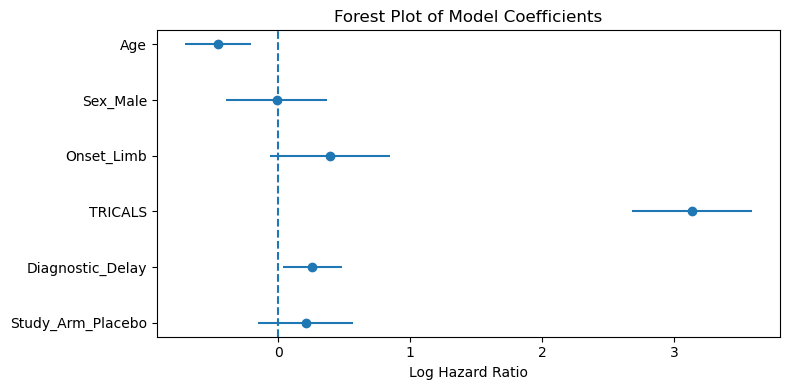

In [85]:
# Get coefficients directly
summary = ro.r.summary(fp_model)

# Try using slotNames to see what's available
# print("Available slots:", ro.r.slotNames(summary))

# Extract using the correct slot name (usually 'coef' or 'coefficients')
coefficients = summary.slots['coef']

# Convert to pandas DataFrame
df_coef = pd.DataFrame(
    np.array(coefficients),
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(z)'],
    index=list(coefficients.rownames)
)

df_coef = df_coef.iloc[1: -1]
df_coef = df_coef.reset_index().rename(columns={"index": "Variable"})


print(df_coef)

#--------------------------------------
z = 1.96  # 95% CI

df_coef["HR"] = (df_coef["Estimate"])
df_coef["CI_lower"] = (df_coef["Estimate"] - z * df_coef["Std. Error"])
df_coef["CI_upper"] = (df_coef["Estimate"] + z * df_coef["Std. Error"])

#--------------------------------------
plt.figure(figsize=(8, 4))

ypos = np.arange(len(df_coef))

# Confidence intervals
plt.hlines(
    y=ypos,
    xmin=df_coef["CI_lower"],
    xmax=df_coef["CI_upper"]
)

# Point estimates
plt.plot(df_coef["Estimate"], ypos, "o")

# Vertical reference line at 0
plt.axvline(0, linestyle="--")

plt.yticks(ypos, df_coef["Variable"])
plt.xlabel("Log Hazard Ratio")
plt.title("Forest Plot of Model Coefficients")

plt.gca().invert_yaxis()  # top-to-bottom
plt.tight_layout()
plt.show()

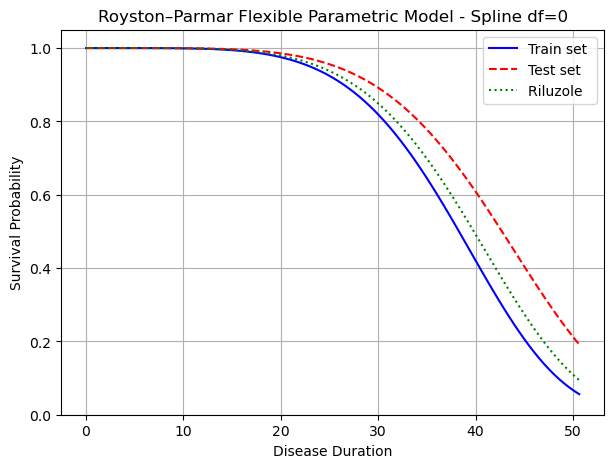

In [87]:
# Common time points for prediction
times = np.linspace(0, df1["Disease_Duration"].max(), 100)

# Helper to create newdata for prediction given a dataframe (train or test)
def make_newdata(df):
    mean_Age = df["Age"].mean()
    mean_TRICALS = df["TRICALS"].mean()
    mean_Vital = df["Vital_capacity"].mean()
    mean_Delay = df["Diagnostic_Delay"].mean()

    mode_Onset = df["Onset_Limb"].mode()[0]
    mode_Sex_Male = df["Sex_Male"].mode()[0]
    # mode_Sex_onset = df["Sex_onset"].mode()[0]
    # mode_Expt = df["Expt_mirocals"].mode()[0]
    mode_Study_Arm_Placebo = df["Study_Arm_Placebo"].mode()[0]

    with localconverter(default_converter + pandas2ri.converter):
        newdata_r = DataFrame({
            "Age": FloatVector([mean_Age]*len(times)),
            "Onset_Limb": IntVector([mode_Onset]*len(times)),
            "TRICALS": FloatVector([mean_TRICALS]*len(times)),
            "Vital_capacity": FloatVector([mean_Vital]*len(times)),
            "Sex_Male": IntVector([mode_Sex_Male]*len(times)),
            # "Sex_onset": IntVector([mode_Sex_onset]*len(times)),
            # "Expt_mirocals": IntVector([mode_Expt]*len(times)),
            "Study_Arm_Placebo": IntVector([mode_Study_Arm_Placebo]*len(times)),
            "Diagnostic_Delay": FloatVector([mean_Delay]*len(times)),
            "Disease_Duration": FloatVector(times)
        })
    return newdata_r

# Prepare newdata for train and test
newdata_train = make_newdata(train_df)
newdata_test = make_newdata(test_df)
newdata_new = make_newdata(df1_new)

# Predict survival probabilities using the fitted model
r_predict = ro.r['predict']

S_train = r_predict(fp_model, newdata=newdata_train, type="surv")
S_test = r_predict(fp_model, newdata=newdata_test, type="surv")
S_new = r_predict(fp_model, newdata=newdata_new, type="surv")

with localconverter(default_converter + pandas2ri.converter):
    py_S_train = np.array(S_train)
    py_S_test = np.array(S_test)
    py_S_new = np.array(S_new)

# Plot
plt.figure(figsize=(7,5))
plt.plot(times, py_S_train, label="Train set ", color='blue')
plt.plot(times, py_S_test, label="Test set ", color='red', linestyle='--')
plt.plot(times, py_S_new, label="Riluzole ", color='green', linestyle=':')

plt.xlabel("Disease Duration")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)
plt.title("Royston–Parmar Flexible Parametric Model - Spline df=0")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
S_train = r_predict(fp_model, newdata=newdata_train, type="hazard")
S_test = r_predict(fp_model, newdata=newdata_test, type="hazard")
S_new = r_predict(fp_model, newdata=newdata_new, type="hazard")

with localconverter(default_converter + pandas2ri.converter):
    py_S_train = np.array(S_train)
    py_S_test = np.array(S_test)
    py_S_new = np.array(S_new)

# Plot
plt.figure(figsize=(7,5))
plt.plot(times, py_S_train, label="Train set (average patient)", color='blue')
plt.plot(times, py_S_test, label="Test set (average patient)", color='red', linestyle='--')
plt.plot(times, py_S_new, label="New data (average patient)", color='green', linestyle=':')

plt.xlabel("Disease Duration")
plt.ylabel("Hazard")
plt.ylim(0, 0.3)
plt.title("Royston–Parmar Flexible Parametric Model - Spline df=0")
plt.legend()
plt.grid(True)
plt.show()

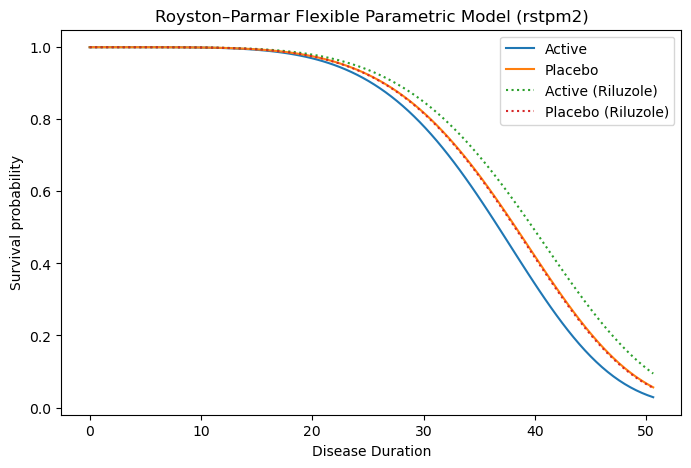

In [88]:
times = np.linspace(0, df1["Disease_Duration"].max(), 100)
times_r = FloatVector(times)

def make_newdata_category(df1, col):
    mean_Age = df1["Age"].mean()
    mean_TRICALS = df1["TRICALS"].mean()
    mean_Vital = df1["Vital_capacity"].mean()
    mean_Delay = df1["Diagnostic_Delay"].mean()

    mode_Onset = df1["Onset_Limb"].mode()[0]
    # mode_Sex_onset = df1["Sex_onset"].mode()[0]
    # mode_Expt = df1["Expt_mirocals"].mode()[0]
    mode_Study_Arm_Placebo = df1["Study_Arm_Placebo"].mode()[0]
    mean_Sex_Male = int(round(df1["Sex_Male"].mean()))

# ────────────────────────────────────────────────────
    # Choose the two Expt levels you want to compare
    level0 = df1[col].unique()[0]
    level1 = df1[col].unique()[1]

    with localconverter(default_converter + pandas2ri.converter):
    # Group 0
        newdata0 = DataFrame({
            "Age": FloatVector([mean_Age]*len(times)),
            "Onset_Limb": IntVector([mode_Onset]*len(times)),
            "TRICALS": FloatVector([mean_TRICALS]*len(times)),
            "Vital_capacity": FloatVector([mean_Vital]*len(times)),
            "Sex_Male": IntVector([mean_Sex_Male]*len(times)),
            # "Study_Arm_Placebo": IntVector([mode_Study_Arm_Placebo]*len(times)),
            # "Sex_onset": FloatVector([mode_Sex_onset]*len(times)),
            col: IntVector([level0]*len(times)),
            "Diagnostic_Delay": FloatVector([mean_Delay]*len(times)),
            "Disease_Duration": times_r
        })

    with localconverter(default_converter + pandas2ri.converter):
    # Group 1
        newdata1 = DataFrame({
            "Age": FloatVector([mean_Age]*len(times)),
            "Onset_Limb": IntVector([mode_Onset]*len(times)),
            "TRICALS": FloatVector([mean_TRICALS]*len(times)),
            "Vital_capacity": FloatVector([mean_Vital]*len(times)),
            "Sex_Male": IntVector([mean_Sex_Male]*len(times)),
            # "Study_Arm_Placebo": IntVector([mode_Study_Arm_Placebo]*len(times)),
            # "Sex_onset": FloatVector([mode_Sex_onset]*len(times)),
            col: IntVector([level1]*len(times)),
            "Diagnostic_Delay": FloatVector([mean_Delay]*len(times)),
            "Disease_Duration": times_r
        })
    return newdata0, newdata1
newdata_0_train, newdata_1_train = make_newdata_category(train_df, 'Study_Arm_Placebo')
newdata_0_test, newdata_1_test = make_newdata_category(test_df, 'Study_Arm_Placebo')
newdata_0_new, newdata_1_new = make_newdata_category(df1_new, 'Study_Arm_Placebo')


# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="surv")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="surv")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="surv")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="surv")

S0_new = r_predict(fp_model, newdata=newdata_0_new, type="surv")
S1_new = r_predict(fp_model, newdata=newdata_1_new, type="surv")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    # py_S0_test = np.array(S0_test)
    # py_S1_test = np.array(S1_test)
    py_S0_new = np.array(S0_new)
    py_S1_new = np.array(S1_new)


plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Active")
plt.plot(times, py_S1_train, label=f"Placebo")
# plt.plot(times, py_S0_test, label=f"Active (Test)", linestyle='--')
# plt.plot(times, py_S1_test, label=f"Placebo (Test)", linestyle='--')
plt.plot(times, py_S0_new, label=f"Active (Riluzole)", linestyle=':')
plt.plot(times, py_S1_new, label=f"Placebo (Riluzole)", linestyle=':')

plt.xlabel("Disease Duration")
plt.ylabel("Survival probability")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()


In [ ]:
newdata_0_train, newdata_1_train = make_newdata_category(train_df, 'Study_Arm_Placebo')
# newdata_0_test, newdata_1_test = make_newdata_category(test_df, 'Study_Arm_Placebo')
newdata_0_new, newdata_1_new = make_newdata_category(df1_new, 'Study_Arm_Placebo')


# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="surv")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="surv")

# S0_test = r_predict(fp_model, newdata=newdata_0_test, type="surv")
# S1_test = r_predict(fp_model, newdata=newdata_1_test, type="surv")

S0_new = r_predict(fp_model, newdata=newdata_0_new, type="surv")
S1_new = r_predict(fp_model, newdata=newdata_1_new, type="surv")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    # py_S0_test = np.array(S0_test)
    # py_S1_test = np.array(S1_test)
    py_S0_new = np.array(S0_new)
    py_S1_new = np.array(S1_new)


plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Active")
plt.plot(times, py_S1_train, label=f"Placebo")
# plt.plot(times, py_S0_test, label=f"Active (Test)", linestyle='--')
# plt.plot(times, py_S1_test, label=f"Placebo (Test)", linestyle='--')
plt.plot(times, py_S0_new, label=f"Active (New)", linestyle=':')
plt.plot(times, py_S1_new, label=f"Placebo (New)", linestyle=':')

plt.xlabel("Disease Duration")
plt.ylabel("Survival probability")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()

In [ ]:
# ────────────────────────────────────────────────────
r_predict = ro.r['predict']

S0_train = r_predict(fp_model, newdata=newdata_0_train, type="hazard")
S1_train = r_predict(fp_model, newdata=newdata_1_train, type="hazard")

S0_test = r_predict(fp_model, newdata=newdata_0_test, type="hazard")
S1_test = r_predict(fp_model, newdata=newdata_1_test, type="hazard")

S0_new = r_predict(fp_model, newdata=newdata_0_new, type="hazard")
S1_new = r_predict(fp_model, newdata=newdata_1_new, type="hazard")

with localconverter(default_converter + pandas2ri.converter):
    py_S0_train = np.array(S0_train)
    py_S1_train = np.array(S1_train)
    py_S0_test = np.array(S0_test)
    py_S1_test = np.array(S1_test)
    py_S0_new = np.array(S0_new)
    py_S1_new = np.array(S1_new)

#_______________________________________________________
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(times, py_S0_train, label=f"Licals")
plt.plot(times, py_S1_train, label=f"Mirocals")
plt.plot(times, py_S0_test, label=f"Licals (Test)", linestyle='--')
plt.plot(times, py_S1_test, label=f"Mirocals (Test)", linestyle='--')
plt.plot(times, py_S0_new, label=f"Licals (New)", linestyle=':')
plt.plot(times, py_S1_new, label=f"Mirocals (New)", linestyle=':')
plt.xlabel("Disease Duration")
plt.ylabel("Hazard")
plt.title("Royston–Parmar Flexible Parametric Model (rstpm2)")
plt.legend()
plt.show()


In [ ]:
# Perform likelihood ratio test between two models



## Prognostic Scores for Baseline Model (fit)

In [ ]:
# prognostic score (linear predictor) with standard error
r_predict = r['predict']

train_df["prognostic_score"] = r_predict(fp_model, type = "link")
# test_df["prognostic_score"] = r_predict(fp_model, type = "link")

train_df.head(3)

In [ ]:
train_df['risk_group'] = pd.qcut(train_df['prognostic_score'], 3, labels=['Low','Medium','High'])

train_df.head(6)
train_df.risk_group.value_counts().to_dict()

In [ ]:
for group in ['Low','Medium','High']:
    subset = train_df[train_df['risk_group']==group]
    kmf = KaplanMeierFitter()
    kmf.fit(subset['Disease_Duration'], subset['Event'], label=group)
    kmf.plot_survival_function()
plt.title("K–M - Prognostic Score")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend(title="Risk Group")
plt.grid(True)
plt.show()

## ***Simulate Virtual Placebo***

In [ ]:
print(f"{train_df.Event.value_counts() / train_df.Event.value_counts().sum()}\n")
print(f"{train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()}\n")
print(f"{train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()}\n")
print(f"{train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()}\n")
print(f"{train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()}\n")

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
pla = train_df['Study_Arm_Placebo'].value_counts() / train_df['Study_Arm_Placebo'].value_counts().sum()
exp = train_df['Expt_mirocals'].value_counts() / train_df['Expt_mirocals'].value_counts().sum()
# eur = train_df['European_Yes'].value_counts() / train_df['European_Yes'].value_counts().sum()


In [ ]:
ons, sex

In [ ]:
df.head(3)

In [ ]:
df1.columns

In [ ]:
df1.head(3)

In [ ]:
corr = train_df[['Age', 'Expt_mirocals','Study_Arm_Placebo','Diagnostic_Delay','Vital_capacity','Sex_Male', 
            	 'Onset_Limb','TRICALS']].corr()
corr

In [ ]:
# from scipy.stats import norm

# def gaussian_copula_samples(n, corr):
#     """
#     Draw correlated U(0,1) samples using a Gaussian copula.
#     corr = correlation matrix (p x p).
#     Returns: U (n x p) matrix of uniforms.
#     """
#     L = np.linalg.cholesky(corr)
#     Z = np.random.normal(size=(n, corr.shape[0]))
#     Z_corr = Z @ L.T
#     U = norm.cdf(Z_corr)
#     return U



# def simulate_cox_dataset(n,baseline='weibull',lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))
    elif baseline == 'weibull':
        # Weibull inverse CDF: T = (-log U)^(1/rho) / (lam*exp(lp))^(1/rho)
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df

In [ ]:
df = df_coef
df

In [ ]:
# df.loc[df["Variable"] == "Age", "Estimate"].values[0]
# ons
# sex[1]
# pla[1]

In [ ]:
var_specs_real = [
    # continuous
    {'name':'Age','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "Age", "Estimate"].values[0]},
    {'name':'TRICALS','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},'coef':df.loc[df["Variable"] == "TRICALS", "Estimate"].values[0]},
    {'name':'Diagnostic_Delay','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
                                                           'coef':df.loc[df["Variable"] == "Diagnostic_Delay", "Estimate"].values[0]},
    # {'name':'Vital_capacity','type':'continuous','dist':{'kind':'normal','mean':0,'sd':1},
    #                                                        'coef':df.loc[df["Variable"] == "Vital capacity", "Estimate"].values[0]},

    # binary
    {'name':'Sex_Male','type':'binary','prob':sex[1],'coef':df.loc[df["Variable"] == "Sex_Male", "Estimate"].values[0]},
    {'name':'Onset_Limb','type':'binary','prob':ons[1],'coef':df.loc[df["Variable"] == "Onset_Limb", "Estimate"].values[0]},
    {'name':'Expt_mirocals','type':'binary','prob':exp[1],'coef':df.loc[df["Variable"] == "Expt_mirocals", "Estimate"].values[0]},
    {'name':'Study_Arm_Placebo','type':'binary','prob':pla[1],'coef':df.loc[df["Variable"] == "Study_Arm_Placebo", "Estimate"].values[0]},

    # # categorical
    # {'name':'Onset_site','type':'categorical',
    #  'levels':['bulbar','limb','other'],'probs':[0.218484,0.746833,0.034683],
    #  'coef':{'limb':1.151159,'other':2.508786},'ref':'bulbar'}
]

corr = train_df[['Age', 'TRICALS', 'Diagnostic_Delay','Sex_Male', 'Onset_Limb', 'Expt_mirocals', 'Study_Arm_Placebo']].corr()

# df_sim = simulate_cox_dataset(n=df1.shape[0], baseline='weibull', lam=0.01, rho=1.5, 
#                               censor_rate=0.3, seed=42, corr=corr, var_specs=var_specs_real)


# df_sim.head(3)

In [ ]:
from scipy.stats import norm

def gaussian_copula_samples(n, corr):
    """
    Draw correlated U(0,1) samples using a Gaussian copula.
    corr = correlation matrix (p x p).
    Returns: U (n x p) matrix of uniforms.
    """
    L = np.linalg.cholesky(corr)
    Z = np.random.normal(size=(n, corr.shape[0]))
    Z_corr = Z @ L.T
    U = norm.cdf(Z_corr)
    return U


from lifelines import NelsonAalenFitter

def estimate_baseline_cumhaz(original_df, time_col='time', event_col='event'):
    """
    Estimate baseline cumulative hazard from real data using Nelson–Aalen.
    """
    naf = NelsonAalenFitter()
    naf.fit(original_df[time_col], event_observed=original_df[event_col])

    H0 = naf.cumulative_hazard_.reset_index()
    H0.columns = ['time', 'cumhaz']
    return H0

H0_df = estimate_baseline_cumhaz(train_df, time_col='Disease_Duration', event_col='Event')
# H0_df

def sample_survival_times_from_empirical_baseline(U, H0_df, linpred):
    """
    Sample survival times using inverse cumulative hazard.

    U: uniform(0,1)
    H0_df: dataframe from estimate_baseline_cumhaz()
    linpred: linear predictor
    """

    # Effective cumulative hazard for each individual
    target = -np.log(U) / np.exp(linpred)

    # Interpolate to get survival times
    return np.interp(target, H0_df['cumhaz'], H0_df['time'])

def sample_survival_times_from_empirical_baseline(U, H0_df, linear_pred):
    """
    Inverse transform sampling using an empirical baseline cumulative hazard.
    """
    H0_t = H0_df["time"].values
    H0_vals = H0_df["cumhaz"].values

    v = -np.log(U) / np.exp(linear_pred)

    # Interpolate inverse of H0
    T = np.interp(v, H0_vals, H0_t, left=H0_t[0], right=H0_t[-1])
    return T

def simulate_cox_dataset(n,baseline='weibull', H0_df=None,lam=0.1,rho=1.0,censor_rate=0.3,seed=None,var_specs=None,corr=None):
    """
    Simulate a Cox proportional hazards dataset WITH correlation among covariates
    using a Gaussian copula approach.
    
    Parameters
    ----------
    n : int
        Sample size.
    baseline : {'weibull','exponential'}
    lam : float
        Baseline hazard parameter.
    rho : float
        Weibull shape parameter.
    censor_rate : float
        Desired censoring proportion (approx).
    seed : int or None
    var_specs : list of dicts
        Each dict must include:
            name : str
            type : {'continuous','binary','categorical'}
            and distribution details.
            coef : float or dict (for categorical)
    corr : array-like or None
        Correlation matrix among the variables in var_specs order.
        If None: variables are generated independently.
        
    Returns
    -------
    DataFrame with:
        time, event, true_survival_time, linear_predictor, `<covariates...>`
    """
    
    rng = np.random.default_rng(seed)
    
    if var_specs is None:
        raise ValueError("var_specs must be provided.")

    p = len(var_specs)

    # ----- STEP 1: Generate correlated uniforms -----
    if corr is None:
        U = None
    else:
        corr = np.asarray(corr)
        if corr.shape != (p, p):
            raise ValueError("corr must be p x p with p = len(var_specs)")
        U = gaussian_copula_samples(n, corr)

    # storage
    df = pd.DataFrame(index=np.arange(n))
    linear_pred = np.zeros(n)

    # ----- STEP 2: Generate covariates with correct marginals but correlated -----
    for j, spec in enumerate(var_specs):
        name = spec['name']
        typ = spec['type'].lower()

        # Uniform samples for this variable
        uj = None if U is None else U[:, j]

        # ============================================================
        # CONTINUOUS
        # ============================================================
        if typ == 'continuous':
            dist = spec.get('dist', {'kind': 'normal', 'mean': 0, 'sd': 1})

            if dist['kind'] == 'normal':
                mu = dist.get('mean', 0)
                sd = dist.get('sd', 1)

                if uj is None:
                    x = rng.normal(mu, sd, size=n)
                else:
                    z = norm.ppf(uj)
                    x = mu + sd * z

            elif dist['kind'] == 'uniform':
                lo = dist.get('low', 0)
                hi = dist.get('high', 1)
                if uj is None:
                    x = rng.uniform(lo, hi, size=n)
                else:
                    x = lo + uj * (hi - lo)

            else:
                raise ValueError(f"Unsupported continuous distribution: {dist['kind']}")

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # BINARY
        # ============================================================
        elif typ == 'binary':
            p_bin = float(spec.get('prob', 0.5))

            if uj is None:
                x = rng.binomial(1, p_bin, size=n)
            else:
                x = (uj < p_bin).astype(int)

            df[name] = x
            coef = float(spec.get('coef', 0.0))
            linear_pred += coef * x

        # ============================================================
        # CATEGORICAL
        # ============================================================
        elif typ == 'categorical':
            levels = list(spec['levels'])
            probs = np.asarray(spec.get('probs', [1 / len(levels)] * len(levels)))

            # boundaries for inverse-CDF categories
            cum = np.cumsum(probs)

            if uj is None:
                cats = rng.choice(levels, p=probs, size=n)
            else:
                # Assign category by uniform bins
                cats = np.empty(n, dtype=object)
                for k, lvl in enumerate(levels):
                    if k == 0:
                        mask = uj <= cum[k]
                    else:
                        mask = (uj > cum[k - 1]) & (uj <= cum[k])
                    cats[mask] = lvl

            df[name] = pd.Categorical(cats, categories=levels)

            # Add to linear predictor
            coef_map = spec.get('coef', {})
            ref = spec.get('ref', levels[0])
            for lvl in levels:
                if lvl == ref:
                    continue
                coef_lvl = float(coef_map.get(lvl, 0.0))
                linear_pred += coef_lvl * (cats == lvl)

        else:
            raise ValueError(f"Unsupported variable type: {typ}")

    # ----- STEP 3: Generate survival times -----
    U_time = rng.uniform(size=n)

    if baseline == "empirical":
        if H0_df is None:
            raise ValueError("You must supply H0_df when using empirical baseline.")
        T = sample_survival_times_from_empirical_baseline(U_time, H0_df, linear_pred)

    elif baseline == 'exponential' or rho == 1.0:
        T = -np.log(U_time) / (lam * np.exp(linear_pred))

    elif baseline == 'weibull':
        T = (-np.log(U_time)) ** (1.0 / rho) / (lam * np.exp(linear_pred)) ** (1.0 / rho)
    else:
        raise ValueError("baseline must be 'exponential' or 'weibull'")

    # ----- STEP 4: Generate censoring -----
    # heuristic to reach the target censoring proportion
    scale_c = max(1e-6, T.mean() * censor_rate / (1 - censor_rate + 1e-9))
    C = rng.exponential(scale=scale_c, size=n)

    observed_time = np.minimum(T, C)
    event = (T <= C).astype(int)

    # ----- STEP 5: Build output -----
    df['time'] = observed_time
    df['event'] = event
    df['true_survival_time'] = T
    df['linear_predictor'] = linear_pred

    cols = ['time', 'event', 'true_survival_time', 'linear_predictor']
    cols += [c for c in df.columns if c not in cols]
    df = df[cols]

    return df



In [ ]:
train_df.Event.value_counts() / train_df.Event.value_counts().sum()

In [ ]:
# Real dataset
# H0_df = estimate_baseline_cumhaz(real_df)

# Simulated dataset
sim_df = simulate_cox_dataset(
    # n=500,
    n=train_df.shape[0],
    var_specs=var_specs_real,
    corr=corr,
    baseline="empirical",
    H0_df=H0_df,
    censor_rate=0.4,
    seed=42
)


In [ ]:
sim_df.head(3)

In [ ]:
# Create interactions
sim_df['Sex_onset'] = sim_df['Sex_Male']*sim_df['Onset_Limb']
sim_df.head(3)

In [ ]:
sim_df.event.value_counts() #/ sim_df.event.value_counts().sum()

In [ ]:
train_df.head(3)

In [ ]:
train_df.Event.value_counts() #/ train_df.event.value_counts().sum()

In [ ]:
ons = train_df['Onset_Limb'].value_counts() / train_df['Onset_Limb'].value_counts().sum()
sex = train_df['Sex_Male'].value_counts() / train_df['Sex_Male'].value_counts().sum()
sex_ons = train_df['Sex_onset'].value_counts() / train_df['Sex_onset'].value_counts().sum()
print(ons, sex, sex_ons)

print("\n---- Simulated data ----")
ons1 = sim_df['Onset_Limb'].value_counts() / sim_df['Onset_Limb'].value_counts().sum()
sex1 = sim_df['Sex_Male'].value_counts() / sim_df['Sex_Male'].value_counts().sum()
sex_ons1 = sim_df['Sex_onset'].value_counts() / sim_df['Sex_onset'].value_counts().sum()

print(ons1, sex1, sex_ons1)

In [ ]:
with conversion.localconverter(pandas2ri.converter):
    r_df_sim = pandas2ri.py2rpy(sim_df)

In [ ]:
# # Define the formula
formula1 = Formula('Surv(true_survival_time, event==1) ~ Age + Study_Arm_Placebo + Onset_Limb + TRICALS + Sex_Male + Sex_onset + Expt_mirocals + Diagnostic_Delay')

# Fit the flexible parametric model
# df = degrees of freedom for spline, adjust as needed
fp_model1 = rstpm2.stpm2(formula1, data=r_df_sim, df=0)
print(ro.r.summary(fp_model1))

In [ ]:
# Get coefficients directly
summary1 = ro.r.summary(fp_model1)

# Try using slotNames to see what's available
# print("Available slots:", ro.r.slotNames(summary))

# Extract using the correct slot name (usually 'coef' or 'coefficients')
coefficients1 = summary1.slots['coef']

# Convert to pandas DataFrame
df_coef1 = pd.DataFrame(
    np.array(coefficients1),
    columns=['Estimate', 'Std. Error', 'z value', 'Pr(z)'],
    index=list(coefficients1.rownames)
)

df_coef1 = df_coef1.iloc[1: -1]
df_coef1 = df_coef1.reset_index().rename(columns={"index": "Variable"})


print(df_coef1)

In [ ]:
df_coef

In [ ]:
coefs = pd.merge(df_coef, df_coef1, on="Variable", suffixes=('_real', '_simulated'))
coefs

In [ ]:
coefs1 = coefs[['Variable', 'Estimate_real', 'Estimate_simulated']]
coefs1

In [ ]:
x = np.arange(len(coefs1))      # positions
width = 0.35                # bar width

plt.figure(figsize=(8, 4))

# Bars
plt.bar(x - width/2, coefs1["Estimate_real"], width, label="Original Data")
plt.bar(x + width/2, coefs1["Estimate_simulated"], width, label="Simulated Data")

# Zero line
plt.axhline(0, linestyle="--", linewidth=1)

# Labels
plt.xticks(x, coefs1["Variable"], rotation=45, ha="right")
plt.ylabel("Coefficient value")
plt.title("Bar Plot of Coefficients: Original vs Simulated Data")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
for col in ['Age', 'TRICALS', 'Diagnostic_Delay']:  # replace with your continuous columns
    plt.figure(figsize=(5,4))
    plt.hist(df1[col], bins=30, alpha=0.5, label='Original', density=True)
    plt.hist(sim_df[col], bins=30, alpha=0.5, label='Simulated', density=True)
    plt.title(f'Distribution of {col}')
    plt.legend()
    plt.show()

In [ ]:
cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Original correlation
sns.heatmap(df1[cols].corr(), annot=True, cmap="coolwarm", ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title("Original Correlation Matrix")

# Simulated correlation
sns.heatmap(sim_df[cols].corr(), annot=True, cmap="coolwarm", ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title("Simulated Correlation Matrix")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import ttest_ind

cols = ['Age', 'TRICALS', 'Diagnostic_Delay']

results = []

for col in cols:
    original = df1[col].dropna()
    simulated = sim_df[col].dropna()

    # Welch t-test
    t_stat, p_val = ttest_ind(original, simulated, equal_var=False)

    # Mean difference
    mean_diff = simulated.mean() - original.mean()

    # Standard errors for CI (Welch)
    se = np.sqrt(original.var()/len(original) + simulated.var()/len(simulated))

    # 95% CI
    ci_low = mean_diff - 1.96 * se
    ci_high = mean_diff + 1.96 * se

    results.append([col, mean_diff, ci_low, ci_high, p_val])

df_plot = pd.DataFrame(results, columns=["Variable", "MeanDiff", "CI_low", "CI_high", "p_value"])


# --------- Forest Plot ---------
plt.figure(figsize=(8, 6))

y_pos = np.arange(len(df_plot))

plt.errorbar(
    df_plot["MeanDiff"], 
    y_pos, 
    xerr=[df_plot["MeanDiff"] - df_plot["CI_low"], df_plot["CI_high"] - df_plot["MeanDiff"]],
    fmt='o', 
    capsize=5
)

plt.axvline(0, color='gray', linestyle='--')

plt.yticks(y_pos, df_plot["Variable"])
plt.xlabel("Mean Difference (Simulated − Original)")
plt.title("Forest Plot of T-Test Mean Differences")

plt.tight_layout()
plt.show()

In [ ]:
# remove the interaction term from the model